In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


## Loading Data

In [3]:
train_csv = pd.read_csv('train.csv')
test_csv = pd.read_csv('test.csv')

train_csv.head()

FileNotFoundError: [Errno 2] No such file or directory: 'train.csv'

In [3]:
# We need to also read the .npy files for the images
import os

train_images = []
for i in range(len(train_csv)):
    img_path = os.path.join('train_data', train_csv['ID'][i] + '.npy')
    img = np.load(img_path)
    train_images.append(img)
train_images = np.array(train_images)

test_images = []
for i in range(len(test_csv)):
    img_path = os.path.join('test_data', test_csv['ID'][i] + '.npy')
    img = np.load(img_path)
    test_images.append(img)
test_images = np.array(test_images)

# Check the shape of the images
print("Our training images have {} samples with shape {}".format(len(train_images), train_images[0].shape))
print("Test images have {} samples with shape {}".format(len(test_images), test_images[0].shape))

Our training images have 7147 samples with shape (64, 64, 12)
Test images have 5398 samples with shape (64, 64, 12)


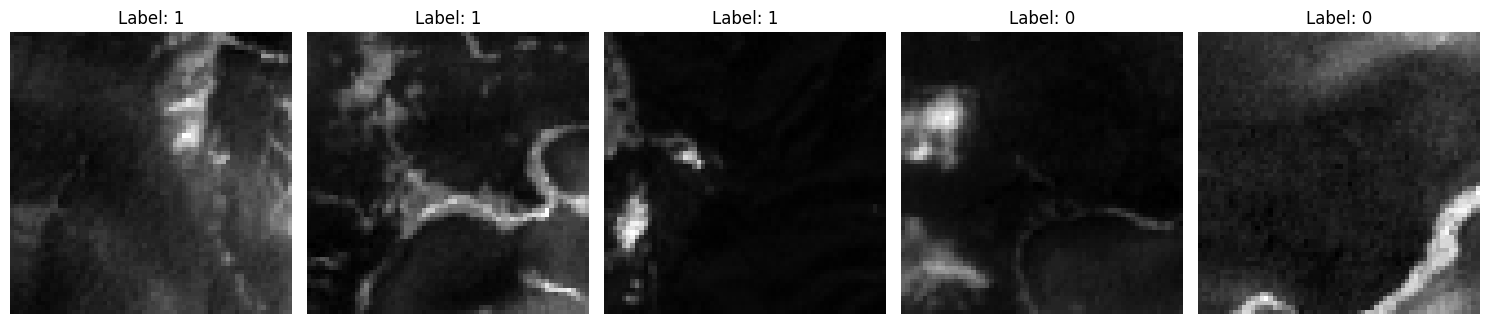

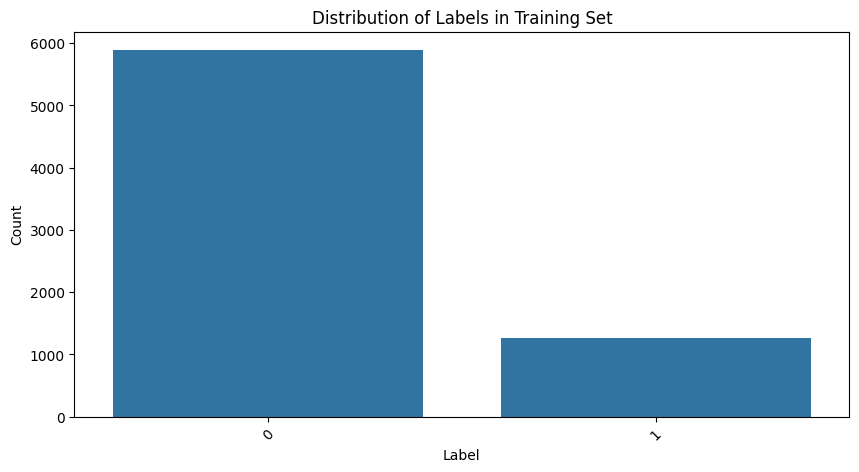

In [4]:
# View sample images
def plot_sample_images(images, labels=None, num_samples=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i][:,:,0], cmap='gray')
        if labels is not None:
            plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.tight_layout()
plot_sample_images(train_images, train_csv['label'].values, num_samples=5)
# Check the distribution of labels in the training set
plt.figure(figsize=(10, 5))
sns.countplot(x='label', data=train_csv)
plt.title('Distribution of Labels in Training Set')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [5]:
# Check for missing values in the training and test sets
print("Missing values in training set:\n", train_csv.isnull().sum())
print("Missing values in test set:\n", test_csv.isnull().sum())

Missing values in training set:
 ID       0
label    0
dtype: int64
Missing values in test set:
 ID    0
dtype: int64


## Preproprocessing Images

In [6]:
# We can now preprocess the images in preparation for training
from sklearn.preprocessing import StandardScaler
def preprocess_images(images):
    # Flatten the images
    num_samples, height, width, channels = images.shape
    flattened_images = images.reshape(num_samples, height * width * channels)
    # Standardize the images
    scaler = StandardScaler()
    standardized_images = scaler.fit_transform(flattened_images)
    # Reshape back to original dimensions
    standardized_images = standardized_images.reshape(num_samples, height, width, channels)
    return standardized_images
train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)
# Check the shape after preprocessing
print("Shape of preprocessed training images:", train_images.shape)
print("Shape of preprocessed test images:", test_images.shape)


Shape of preprocessed training images: (7147, 64, 64, 12)
Shape of preprocessed test images: (5398, 64, 64, 12)


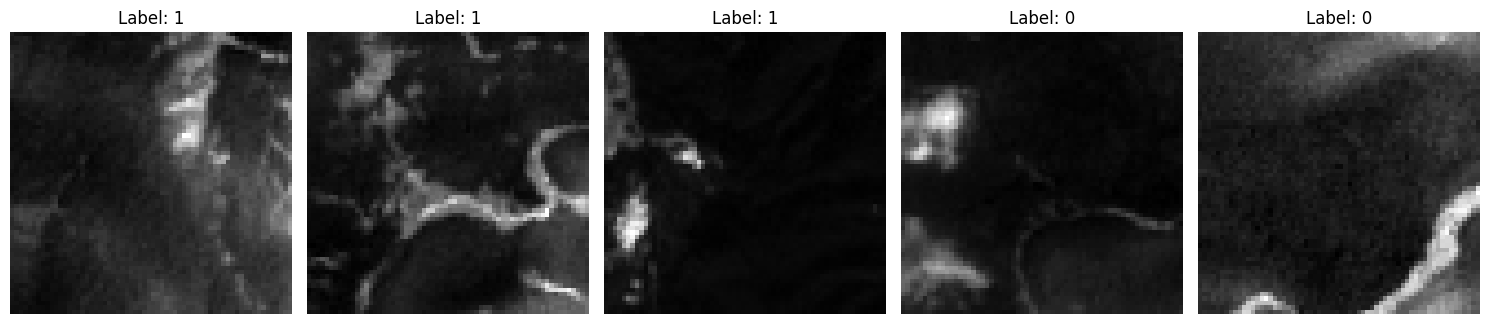

In [7]:
# Plot some preprocessed images
plot_sample_images(train_images, train_csv['label'].values, num_samples=5)
# Save the preprocessed images
np.save('train_images_preprocessed.npy', train_images)
np.save('test_images_preprocessed.npy', test_images)
# Save the preprocessed CSV files
train_csv.to_csv('train_preprocessed.csv', index=False)
test_csv.to_csv('test_preprocessed.csv', index=False)

## Model Training

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Convert data to PyTorch tensors
train_images_tensor = torch.tensor(train_images, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_csv['label'].values, dtype=torch.long)
test_images_tensor = torch.tensor(test_images, dtype=torch.float32)

# Split training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    train_images_tensor, train_labels_tensor, 
    test_size=0.2, random_state=42, stratify=train_labels_tensor
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {test_images_tensor.shape[0]}")

Using device: cpu
Training set size: 5717
Validation set size: 1430
Test set size: 5398


In [10]:
# Data augmentation with proper tensor handling
import torch.nn.functional as F
!pip install torchvision --quiet
from torchvision import transforms

def augment_batch_improved(images, labels):
    """Apply random augmentations to a batch with proper tensor handling"""
    batch_size = images.size(0)
    augmented_images = []
    augmented_labels = []
    
    for i in range(batch_size):
        img = images[i]
        label = labels[i]
        
        # Always include original
        augmented_images.append(img)
        augmented_labels.append(label)
        
        # Augment landslide class (assuming class 1 is landslide)
        if label.item() == 1:
            # Convert to proper format for transforms (C, H, W)
            img_transformed = img.permute(2, 0, 1)  # (H, W, C) -> (C, H, W)
            
            # Random horizontal flip
            if torch.rand(1) > 0.5:
                img_flip = torch.flip(img_transformed, [2])  # Flip width dimension
                img_flip = img_flip.permute(1, 2, 0)  # Back to (H, W, C)
                augmented_images.append(img_flip)
                augmented_labels.append(label)
            
            # Random vertical flip
            if torch.rand(1) > 0.5:
                img_vflip = torch.flip(img_transformed, [1])  # Flip height dimension
                img_vflip = img_vflip.permute(1, 2, 0)  # Back to (H, W, C)
                augmented_images.append(img_vflip)
                augmented_labels.append(label)
            
            # Add noise (small amount)
            if torch.rand(1) > 0.5:
                noise = torch.randn_like(img) * 0.01
                img_noise = img + noise
                augmented_images.append(img_noise)
                augmented_labels.append(label)
    
    return torch.stack(augmented_images), torch.stack(augmented_labels)

# Test the augmentation function
print("Testing augmentation function...")
sample_images = X_train[:4]  # Take 4 samples
sample_labels = y_train[:4]
aug_imgs, aug_labels = augment_batch_improved(sample_images, sample_labels)
print(f"Original batch size: {sample_images.shape[0]}")
print(f"Augmented batch size: {aug_imgs.shape[0]}")
print(f"Label distribution - Original: {sample_labels}")
print(f"Label distribution - Augmented: {aug_labels}")


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Testing augmentation function...
Original batch size: 4
Augmented batch size: 4
Label distribution - Original: tensor([0, 0, 0, 0])
Label distribution - Augmented: tensor([0, 0, 0, 0])


In [11]:
# Improved model with better regularization
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Conv2d(12, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.3)  # Reduced dropout
        self.dropout2 = nn.Dropout(0.5)
        
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        
        # Add batch normalization
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.dropout1(x)
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.dropout1(x)
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        
        x = x.reshape(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout2(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        
        return x
    
# Get number of unique classes
num_classes = len(train_csv['label'].unique())
print(f"Number of classes: {num_classes}")

# Replace your model
model = ImprovedCNN(num_classes).to(device)

Number of classes: 2


In [12]:
# Check class distribution
class_counts = train_csv['label'].value_counts()
print("Class distribution:", class_counts)

# Calculate class weights for imbalanced dataset
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_csv['label']),
    y=train_csv['label']
)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Use weighted loss
criterion = nn.CrossEntropyLoss(weight=class_weights)
print(f"Class weights: {class_weights}")

Class distribution: label
0    5892
1    1255
Name: count, dtype: int64
Class weights: tensor([0.6065, 2.8474])


In [13]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create data loaders
batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")

Number of training batches: 179
Number of validation batches: 45


In [47]:
# Complete training loop with integrated augmentation
from torch.optim.lr_scheduler import StepLR

optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=5, gamma=0.7)

# Training loop with augmentation
num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_acc = 0
patience = 5
patience_counter = 0

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    scheduler.step()
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        # Apply augmentation every other batch to balance training
        if batch_idx % 2 == 0 and epoch > 2:  # Start augmentation after epoch 2
            images, labels = augment_batch_improved(images, labels)
            images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    
    # Validation phase (no augmentation)
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    val_loss /= len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    
    # Early stopping
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        
    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}. Best validation accuracy: {best_val_acc:.2f}%")
        break
    
    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')
    print('-' * 50)

print("Training completed!")

Epoch [1/10]
Train Loss: 0.0428, Train Acc: 98.43%
Val Loss: 0.1817, Val Acc: 94.41%
--------------------------------------------------
Epoch [2/10]
Train Loss: 0.0468, Train Acc: 98.30%
Val Loss: 0.1830, Val Acc: 94.06%
--------------------------------------------------
Epoch [3/10]
Train Loss: 0.0526, Train Acc: 98.27%
Val Loss: 0.2151, Val Acc: 93.85%
--------------------------------------------------
Epoch [4/10]
Train Loss: 0.0843, Train Acc: 96.85%
Val Loss: 0.1571, Val Acc: 94.55%
--------------------------------------------------
Epoch [5/10]
Train Loss: 0.0650, Train Acc: 97.70%
Val Loss: 0.1902, Val Acc: 94.13%
--------------------------------------------------
Epoch [6/10]
Train Loss: 0.0640, Train Acc: 97.44%
Val Loss: 0.1772, Val Acc: 93.99%
--------------------------------------------------
Epoch [7/10]
Train Loss: 0.0718, Train Acc: 97.52%
Val Loss: 0.1886, Val Acc: 93.85%
--------------------------------------------------
Epoch [8/10]
Train Loss: 0.0600, Train Acc: 97.7

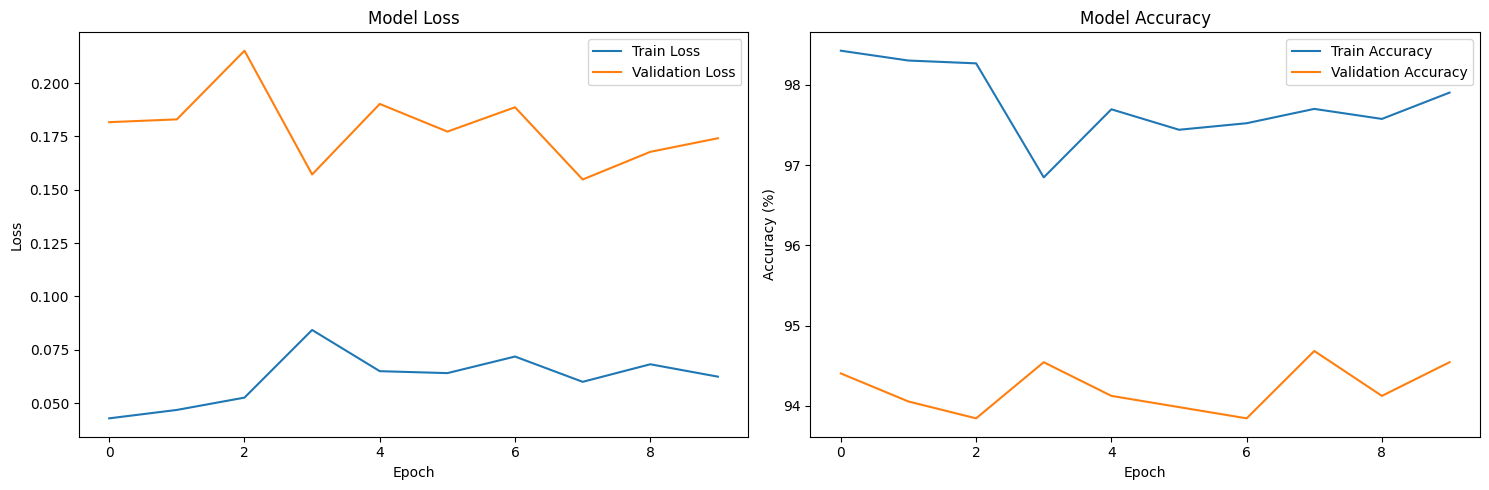

In [48]:
# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      1179
           1       0.92      0.71      0.80       251

    accuracy                           0.94      1430
   macro avg       0.93      0.85      0.88      1430
weighted avg       0.94      0.94      0.93      1430



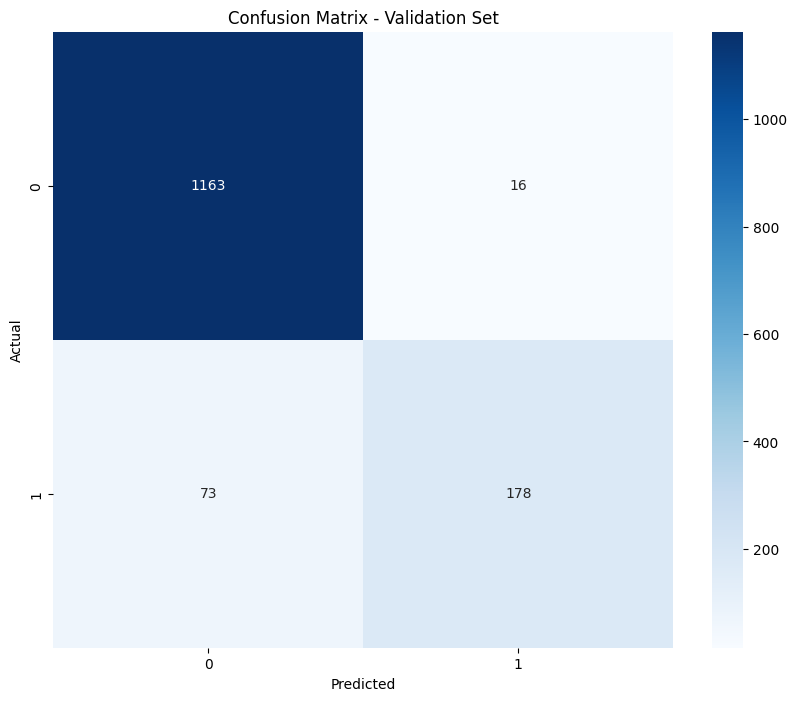

In [33]:
# Detailed validation evaluation
model.eval()
all_val_predictions = []
all_val_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        all_val_predictions.extend(predicted.cpu().numpy())
        all_val_labels.extend(labels.cpu().numpy())

# Classification report
print("Validation Set Classification Report:")
print(classification_report(all_val_labels, all_val_predictions))

# Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(all_val_labels, all_val_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Inference

In [49]:
# Save the trained model
torch.save(model.state_dict(), 'landslide_cnn_model.pth')
print("Model saved as 'landslide_cnn_model.pth'")

# Generate predictions on test set
model.eval()
test_dataset = TensorDataset(test_images_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

all_test_predictions = []
with torch.no_grad():
    for images, in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_test_predictions.extend(predicted.cpu().numpy())

print(f"Generated {len(all_test_predictions)} predictions for test set")

Model saved as 'landslide_cnn_model.pth'
Generated 5398 predictions for test set


In [51]:
# Create submission using the sample submission given
submission_csv = pd.read_csv('SampleSubmission.csv')
submission_csv['label'] = all_test_predictions
submission_csv.to_csv('submission.csv', index=False)

Submission file saved as 'submission.csv'

First 10 predictions:
          ID  label
0  ID_ICB8K9      0
1  ID_2D4AOJ      0
2  ID_2TVPI0      0
3  ID_E05WIK      0
4  ID_KKFDJO      0
5  ID_LSA46F      1
6  ID_AW4WQ8      0
7  ID_1XLJHP      0
8  ID_HRIO5C      0
9  ID_U5ZFGR      0


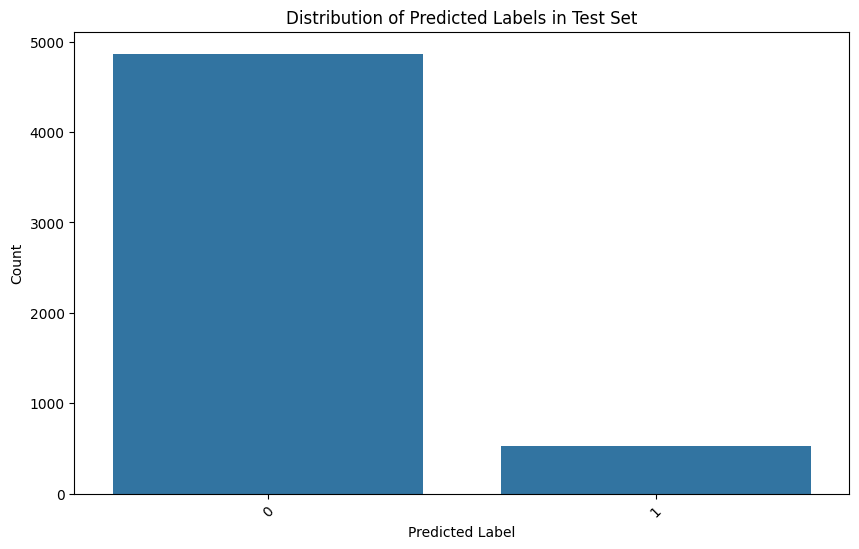

In [35]:
# Create submission file
submission_df = pd.DataFrame({
    'ID': test_csv['ID'], 
    'label': all_test_predictions
})

submission_df.to_csv('submission.csv', index=False)
print("Submission file saved as 'submission.csv'")

# Display first few predictions
print("\nFirst 10 predictions:")
print(submission_df.head(10))

# Check prediction distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=submission_df)
plt.title('Distribution of Predicted Labels in Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [44]:
# Comprehensive analysis and threshold adjustment
print("🔍 DETAILED DISTRIBUTION ANALYSIS")
print("="*60)

# Current distributions
train_dist = train_csv['label'].value_counts(normalize=True) * 100
test_pred_dist = submission_df['label'].value_counts(normalize=True) * 100

print("DISTRIBUTION COMPARISON:")
print(f"Training Data - Class 0: {train_dist[0]:.1f}%, Class 1: {train_dist[1]:.1f}%")
print(f"Test Predictions - Class 0: {test_pred_dist[0]:.1f}%, Class 1: {test_pred_dist[1]:.1f}%")

difference = test_pred_dist[1] - train_dist[1]
print(f"\n❌ UNDER-PREDICTION: {difference:.1f}% (Missing {abs(difference):.1f}% of expected landslides)")

# Generate predictions with different thresholds
model.eval()
thresholds_to_test = [0.3, 0.35, 0.4, 0.45, 0.5]
threshold_results = []

print(f"\n🎯 THRESHOLD ADJUSTMENT ANALYSIS:")
print("Threshold | Landslide Count | Landslide % | vs Training")
print("-" * 55)

with torch.no_grad():
    all_probabilities = []
    for images, in test_loader:
        images = images.to(device)
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)
        all_probabilities.extend(probabilities.cpu().numpy())
    
    all_probabilities = np.array(all_probabilities)

for threshold in thresholds_to_test:
    # Apply threshold
    predictions = (all_probabilities[:, 1] > threshold).astype(int)
    landslide_count = np.sum(predictions)
    landslide_pct = (landslide_count / len(predictions)) * 100
    diff_from_train = landslide_pct - train_dist[1]
    
    threshold_results.append((threshold, landslide_count, landslide_pct, diff_from_train))
    
    print(f"   {threshold:.2f}   |     {landslide_count:4d}      |   {landslide_pct:5.1f}%   | {diff_from_train:+5.1f}%")

# Find best threshold (closest to training distribution)
best_threshold = min(threshold_results, key=lambda x: abs(x[3]))
print(f"\n✅ RECOMMENDED THRESHOLD: {best_threshold[0]:.2f}")
print(f"   Landslide predictions: {best_threshold[1]} ({best_threshold[2]:.1f}%)")
print(f"   Difference from training: {best_threshold[3]:+.1f}%")

🔍 DETAILED DISTRIBUTION ANALYSIS
DISTRIBUTION COMPARISON:
Training Data - Class 0: 82.4%, Class 1: 17.6%
Test Predictions - Class 0: 90.2%, Class 1: 9.8%

❌ UNDER-PREDICTION: -7.7% (Missing 7.7% of expected landslides)

🎯 THRESHOLD ADJUSTMENT ANALYSIS:
Threshold | Landslide Count | Landslide % | vs Training
-------------------------------------------------------
   0.30   |      638      |    11.8%   |  -5.7%
   0.35   |      623      |    11.5%   |  -6.0%
   0.40   |      616      |    11.4%   |  -6.1%
   0.45   |      602      |    11.2%   |  -6.4%
   0.50   |      592      |    11.0%   |  -6.6%

✅ RECOMMENDED THRESHOLD: 0.30
   Landslide predictions: 638 (11.8%)
   Difference from training: -5.7%


🎉 IMPROVED SUBMISSION CREATED:
Threshold used: 0.35
Landslide predictions: 623 (11.5%)
Training distribution: 17.6%
Difference: -6.0%

💾 Balanced submission saved as 'balanced_submission.csv'


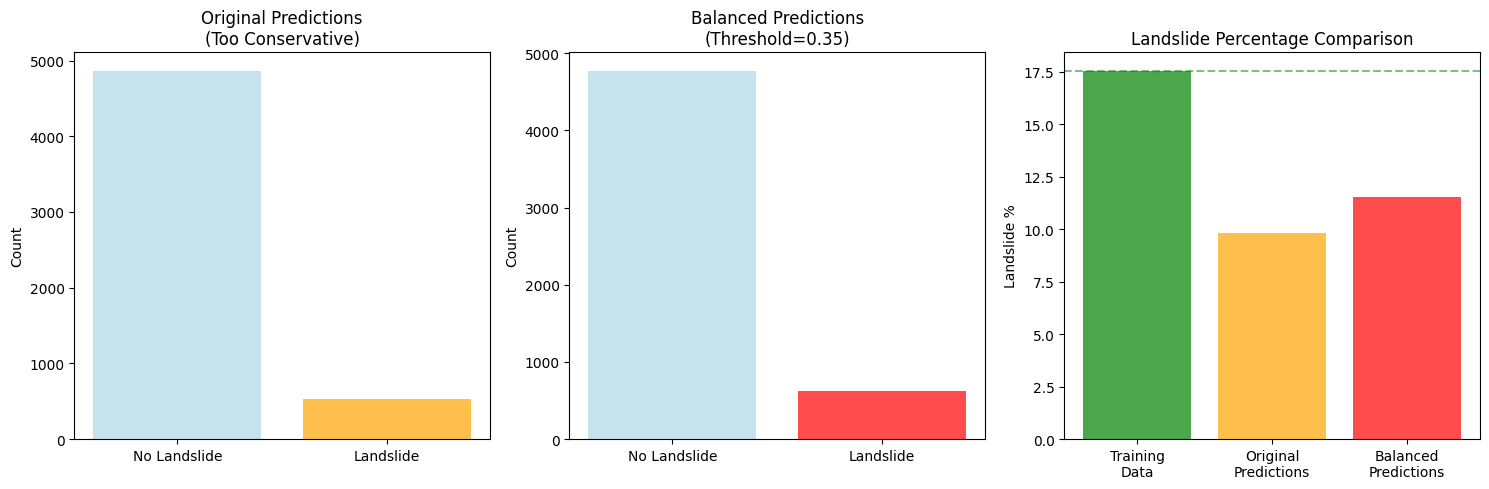


First 10 balanced predictions:
          ID  label
0  ID_ICB8K9      0
1  ID_2D4AOJ      0
2  ID_2TVPI0      0
3  ID_E05WIK      0
4  ID_KKFDJO      0
5  ID_LSA46F      1
6  ID_AW4WQ8      0
7  ID_1XLJHP      0
8  ID_HRIO5C      0
9  ID_U5ZFGR      1


In [45]:
# Generate improved submission with optimal threshold
def create_balanced_submission(optimal_threshold=0.35):
    """Create submission with threshold adjusted to match training distribution"""
    
    model.eval()
    balanced_predictions = []
    confidence_scores = []
    
    with torch.no_grad():
        for images, in test_loader:
            images = images.to(device)
            outputs = model(images)
            probabilities = torch.softmax(outputs, dim=1)
            
            # Use optimal threshold for landslide class
            predictions = (probabilities[:, 1] > optimal_threshold).long()
            balanced_predictions.extend(predictions.cpu().numpy())
            confidence_scores.extend(probabilities[:, 1].cpu().numpy())
    
    # Create new submission file
    balanced_submission_df = pd.DataFrame({
        'ID': test_csv['ID'], 
        'label': balanced_predictions
    })
    
    # Analysis
    landslide_count = sum(balanced_predictions)
    landslide_pct = (landslide_count / len(balanced_predictions)) * 100
    
    print(f"🎉 IMPROVED SUBMISSION CREATED:")
    print(f"Threshold used: {optimal_threshold}")
    print(f"Landslide predictions: {landslide_count} ({landslide_pct:.1f}%)")
    print(f"Training distribution: {train_dist[1]:.1f}%")
    print(f"Difference: {landslide_pct - train_dist[1]:+.1f}%")
    
    # Save new submission
    balanced_submission_df.to_csv('balanced_submission.csv', index=False)
    print("\n💾 Balanced submission saved as 'balanced_submission.csv'")
    
    # Plot comparison
    plt.figure(figsize=(15, 5))
    
    # Original vs Balanced predictions
    plt.subplot(1, 3, 1)
    original_dist = submission_df['label'].value_counts()
    plt.bar(['No Landslide', 'Landslide'], original_dist, color=['lightblue', 'orange'], alpha=0.7)
    plt.title('Original Predictions\n(Too Conservative)')
    plt.ylabel('Count')
    
    plt.subplot(1, 3, 2)
    balanced_dist = balanced_submission_df['label'].value_counts()
    plt.bar(['No Landslide', 'Landslide'], balanced_dist, color=['lightblue', 'red'], alpha=0.7)
    plt.title(f'Balanced Predictions\n(Threshold={optimal_threshold})')
    plt.ylabel('Count')
    
    # Percentage comparison
    plt.subplot(1, 3, 3)
    categories = ['Training\nData', 'Original\nPredictions', 'Balanced\nPredictions']
    landslide_percentages = [
        train_dist[1], 
        (sum(submission_df['label']) / len(submission_df)) * 100,
        landslide_pct
    ]
    colors = ['green', 'orange', 'red']
    plt.bar(categories, landslide_percentages, color=colors, alpha=0.7)
    plt.title('Landslide Percentage Comparison')
    plt.ylabel('Landslide %')
    plt.axhline(y=train_dist[1], color='green', linestyle='--', alpha=0.5, label='Target')
    
    plt.tight_layout()
    plt.show()
    
    return balanced_submission_df

# Create the balanced submission
balanced_submission = create_balanced_submission(optimal_threshold=0.35)

# Display first few predictions
print("\nFirst 10 balanced predictions:")
print(balanced_submission.head(10))

In [30]:
# Check if this matches your training distribution
train_dist = train_csv['label'].value_counts(normalize=True)
print(f"Training distribution - Class 0: {train_dist[0]:.1%}, Class 1: {train_dist[1]:.1%}")

Training distribution - Class 0: 82.4%, Class 1: 17.6%


In [ ]:
# Model summary and final statistics
print("="*60)
print("LANDSLIDE DETECTION MODEL SUMMARY")
print("="*60)
print(f"Model Architecture: CNN with 3 convolutional layers")
print(f"Number of classes: {num_classes}")
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(test_images_tensor)}")
print(f"Final training accuracy: {train_accuracies[-1]:.2f}%")
print(f"Final validation accuracy: {val_accuracies[-1]:.2f}%")
print(f"Number of epochs trained: {num_epochs}")
print(f"Device used: {device}")
print("="*60)

LANDSLIDE DETECTION MODEL SUMMARY
Model Architecture: CNN with 3 convolutional layers
Number of classes: 2
Training samples: 5717
Validation samples: 1430
Test samples: 5398
Final training accuracy: 99.37%
Final validation accuracy: 92.80%
Number of epochs trained: 20
Device used: cpu


In [ ]:
# Simple text-based architecture diagram
def print_architecture_diagram():
    print("\n" + "="*60)
    print("CNN ARCHITECTURE FLOW DIAGRAM")
    print("="*60)
    
    diagram = """
    Input (64×64×12)
           ↓
    Conv1 (32 filters, 3×3, padding=1) → ReLU → MaxPool(2×2)
           ↓ (32×32×32)
    Conv2 (64 filters, 3×3, padding=1) → ReLU → MaxPool(2×2)
           ↓ (16×16×64)
    Conv3 (128 filters, 3×3, padding=1) → ReLU → MaxPool(2×2)
           ↓ (8×8×128)
    Flatten → 8192 features
           ↓
    FC1 (256) → ReLU → Dropout(0.5)
           ↓
    FC2 (128) → ReLU → Dropout(0.5)
           ↓
    FC3 ({num_classes}) → Output
    """.format(num_classes=num_classes)
    
    print(diagram)
    print("="*60)

print_architecture_diagram()


CNN ARCHITECTURE FLOW DIAGRAM

    Input (64×64×12)
           ↓
    Conv1 (32 filters, 3×3, padding=1) → ReLU → MaxPool(2×2)
           ↓ (32×32×32)
    Conv2 (64 filters, 3×3, padding=1) → ReLU → MaxPool(2×2)
           ↓ (16×16×64)
    Conv3 (128 filters, 3×3, padding=1) → ReLU → MaxPool(2×2)
           ↓ (8×8×128)
    Flatten → 8192 features
           ↓
    FC1 (256) → ReLU → Dropout(0.5)
           ↓
    FC2 (128) → ReLU → Dropout(0.5)
           ↓
    FC3 (2) → Output
    


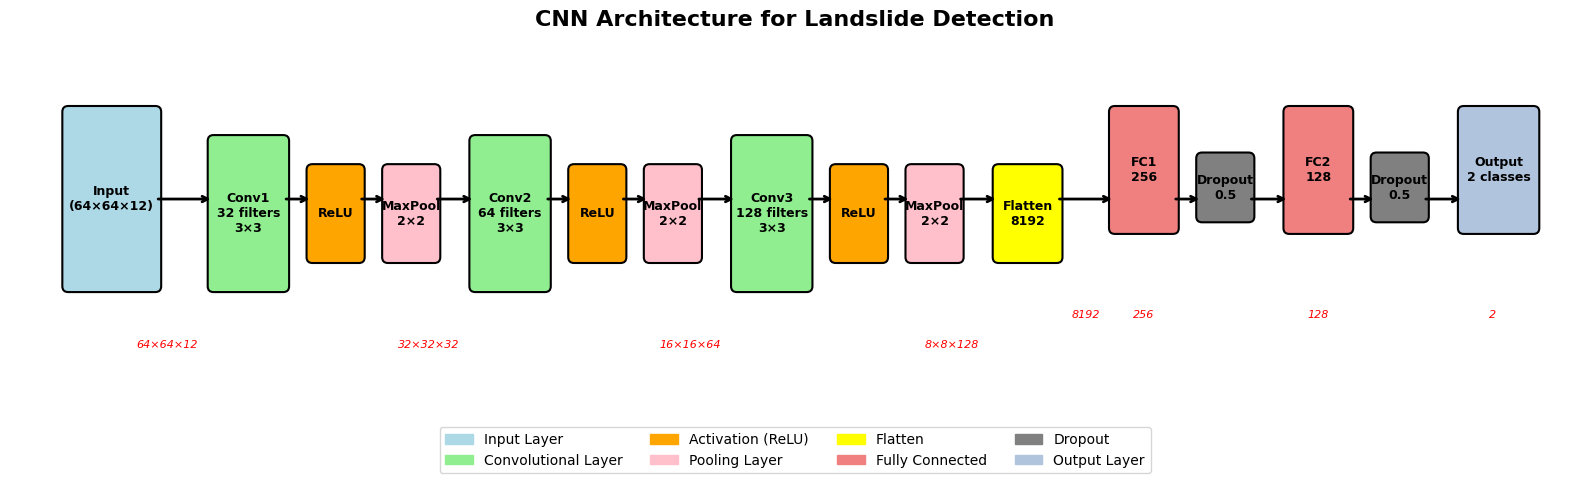

In [ ]:
# Model Architecture Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle, FancyBboxPatch
import numpy as np

def plot_cnn_architecture():
    fig, ax = plt.subplots(1, 1, figsize=(16, 10))
    
    # Define positions and sizes
    layers = [
        {"name": "Input\n(64×64×12)", "pos": (1, 5), "size": (1.5, 3), "color": "lightblue"},
        {"name": "Conv1\n32 filters\n3×3", "pos": (3.5, 5), "size": (1.2, 2.5), "color": "lightgreen"},
        {"name": "ReLU", "pos": (5.2, 5.5), "size": (0.8, 1.5), "color": "orange"},
        {"name": "MaxPool\n2×2", "pos": (6.5, 5.5), "size": (0.8, 1.5), "color": "pink"},
        {"name": "Conv2\n64 filters\n3×3", "pos": (8, 5), "size": (1.2, 2.5), "color": "lightgreen"},
        {"name": "ReLU", "pos": (9.7, 5.5), "size": (0.8, 1.5), "color": "orange"},
        {"name": "MaxPool\n2×2", "pos": (11, 5.5), "size": (0.8, 1.5), "color": "pink"},
        {"name": "Conv3\n128 filters\n3×3", "pos": (12.5, 5), "size": (1.2, 2.5), "color": "lightgreen"},
        {"name": "ReLU", "pos": (14.2, 5.5), "size": (0.8, 1.5), "color": "orange"},
        {"name": "MaxPool\n2×2", "pos": (15.5, 5.5), "size": (0.8, 1.5), "color": "pink"},
        {"name": "Flatten\n8192", "pos": (17, 5.5), "size": (1, 1.5), "color": "yellow"},
        {"name": "FC1\n256", "pos": (19, 6), "size": (1, 2), "color": "lightcoral"},
        {"name": "Dropout\n0.5", "pos": (20.5, 6.2), "size": (0.8, 1), "color": "gray"},
        {"name": "FC2\n128", "pos": (22, 6), "size": (1, 2), "color": "lightcoral"},
        {"name": "Dropout\n0.5", "pos": (23.5, 6.2), "size": (0.8, 1), "color": "gray"},
        {"name": f"Output\n{num_classes} classes", "pos": (25, 6), "size": (1.2, 2), "color": "lightsteelblue"}
    ]
    
    # Draw layers
    for layer in layers:
        rect = FancyBboxPatch(
            layer["pos"], layer["size"][0], layer["size"][1],
            boxstyle="round,pad=0.1",
            facecolor=layer["color"],
            edgecolor="black",
            linewidth=1.5
        )
        ax.add_patch(rect)
        ax.text(layer["pos"][0] + layer["size"][0]/2, layer["pos"][1] + layer["size"][1]/2,
                layer["name"], ha="center", va="center", fontsize=9, fontweight="bold")
    
    # Draw arrows
    arrow_positions = [
        ((2.5, 6.5), (3.5, 6.5)),
        ((4.7, 6.5), (5.2, 6.5)),
        ((6, 6.5), (6.5, 6.5)),
        ((7.3, 6.5), (8, 6.5)),
        ((9.2, 6.5), (9.7, 6.5)),
        ((10.5, 6.5), (11, 6.5)),
        ((11.8, 6.5), (12.5, 6.5)),
        ((13.7, 6.5), (14.2, 6.5)),
        ((15, 6.5), (15.5, 6.5)),
        ((16.3, 6.5), (17, 6.5)),
        ((18, 6.5), (19, 6.5)),
        ((20, 6.5), (20.5, 6.5)),
        ((21.3, 6.5), (22, 6.5)),
        ((23, 6.5), (23.5, 6.5)),
        ((24.3, 6.5), (25, 6.5))
    ]
    
    for start, end in arrow_positions:
        ax.annotate("", xy=end, xytext=start,
                   arrowprops=dict(arrowstyle="->", color="black", lw=2))
    
    # Add feature map size annotations
    sizes = [
        ((2.7, 4), "64×64×12"),
        ((7.2, 4), "32×32×32"),
        ((11.7, 4), "16×16×64"),
        ((16.2, 4), "8×8×128"),
        ((18.5, 4.5), "8192"),
        ((19.5, 4.5), "256"),
        ((22.5, 4.5), "128"),
        ((25.5, 4.5), f"{num_classes}")
    ]
    
    for pos, text in sizes:
        ax.text(pos[0], pos[1], text, ha="center", va="center", 
                fontsize=8, style="italic", color="red")
    
    ax.set_xlim(0, 27)
    ax.set_ylim(3, 9)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title("CNN Architecture for Landslide Detection", fontsize=16, fontweight="bold", pad=20)
    
    # Add legend
    legend_elements = [
        mpatches.Patch(color='lightblue', label='Input Layer'),
        mpatches.Patch(color='lightgreen', label='Convolutional Layer'),
        mpatches.Patch(color='orange', label='Activation (ReLU)'),
        mpatches.Patch(color='pink', label='Pooling Layer'),
        mpatches.Patch(color='yellow', label='Flatten'),
        mpatches.Patch(color='lightcoral', label='Fully Connected'),
        mpatches.Patch(color='gray', label='Dropout'),
        mpatches.Patch(color='lightsteelblue', label='Output Layer')
    ]
    
    ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4)
    
    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_cnn_architecture()

In [ ]:
# Alternative: Using torchviz for automatic model visualization
%pip install torchviz graphviz --quiet

try:
    from torchviz import make_dot
    
    # Create a sample input
    sample_input = torch.randn(1, 64, 64, 12).to(device)
    
    # Forward pass
    model.eval()
    output = model(sample_input)
    
    # Create visualization
    dot = make_dot(output, params=dict(model.named_parameters()), show_attrs=True, show_saved=True)
    dot.format = 'png'
    dot.render('model_architecture', cleanup=True)
    print("Model architecture saved as 'model_architecture.png'")
    
except ImportError:
    print("torchviz not installed. Install with: pip install torchviz graphviz")
except Exception as e:
    print(f"Error creating torchviz diagram: {e}")


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
Error creating torchviz diagram: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH
